# Boosting (XGBoost) Modelling on Ebay Dataset 

Getting the data

In [25]:
import pandas as pd
import numpy as np

In [26]:
train_ebay = pd.read_csv("train_ebay.csv")
test_ebay = pd.read_csv("test_ebay.csv")

In [27]:
train_ebay.head()

,date,symbol,open,close,low,high,volume
0,2010-01-04,EBAY,23.719999,23.900000,23.619999,23.979998,22511600.0
1,2010-01-05,EBAY,23.790000,23.650000,23.500000,23.900000,26683100.0
2,2010-01-06,EBAY,23.629998,23.500000,23.440000,23.800000,26368600.0
3,2010-01-07,EBAY,23.490000,23.229998,23.169999,23.490000,25220000.0
4,2010-01-08,EBAY,23.190000,23.509999,23.100000,23.640000,30484000.0


Data Manipulation

In [28]:
#Sorting the dataset based on dates
train_ebay = train_ebay.sort_values("date")
test_ebay  = test_ebay.sort_values("date")

#get the date in the particular format i.e yyyy-mm-dd.
train_ebay['date'] = train_ebay['date'].astype('datetime64[D]')
test_ebay['date'] = test_ebay['date'].astype('datetime64[D]')

In [29]:
#idea - We will take past 2 days closing price values along with the diference between the previous day's closing and opening price

def get_new_data(dataset):
    
    #last day closing price
    
    dataset.loc[0,'close_1'] = dataset.loc[0,'open']
    
    for i in range(1,len(dataset)):
        dataset.loc[i,'close_1'] = dataset.loc[i-1,'close']
    
    #Last to last day closing price
    
    dataset.loc[0,'close_2'] = dataset.loc[0,'open']
    dataset.loc[1,'close_2'] = dataset.loc[1,'open']
    
    for i in range(2,len(dataset)):
        dataset.loc[i,'close_2'] = dataset.loc[i-2,'close']
        
        
    #difference between previous day's opening and closing price
    
    dataset.loc[0,'prev_diff'] = 0
    
    for i in range(1,len(dataset)):
        dataset.loc[i,'prev_diff'] = dataset.loc[i-1,'close'] - dataset.loc[i-1,'open'] 
    
    
        
    return dataset

In [30]:
train_ebay = get_new_data(train_ebay)
test_ebay = get_new_data(test_ebay)

In [75]:
train_ebay.head()

,date,symbol,open,close,low,high,volume,close_1,close_2,prev_diff
0,2010-01-04,EBAY,23.719999,23.900000,23.619999,23.979998,22511600.0,23.719999,23.719999,0.000000
1,2010-01-05,EBAY,23.790000,23.650000,23.500000,23.900000,26683100.0,23.900000,23.790000,0.180001
2,2010-01-06,EBAY,23.629998,23.500000,23.440000,23.800000,26368600.0,23.650000,23.900000,-0.140000
3,2010-01-07,EBAY,23.490000,23.229998,23.169999,23.490000,25220000.0,23.500000,23.650000,-0.129998
4,2010-01-08,EBAY,23.190000,23.509999,23.100000,23.640000,30484000.0,23.229998,23.500000,-0.260002


In [34]:
#getting the dependent variable
Y_train = train_ebay["close"]
Y_test = test_ebay["close"]

#dropping symbol and closing price from the X_train and X_test datasets
X_train = train_ebay.drop(["symbol" , "close" ] , axis = 1)
X_test = test_ebay.drop(["symbol" , "close" ] , axis = 1)

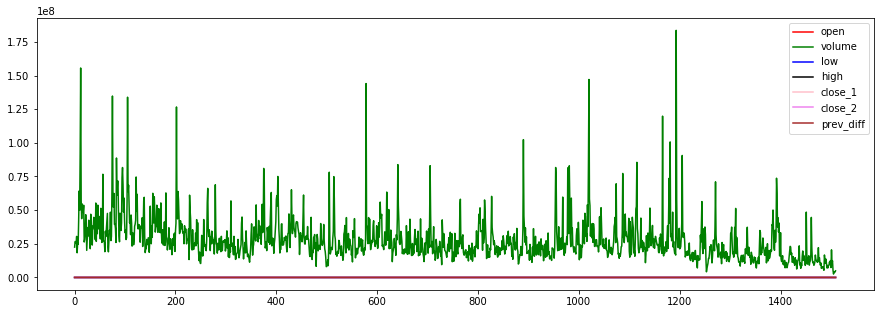

In [35]:
#Plots to check how they are changing with time

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5));
plt.plot(X_train.open.values, color='red', label='open')
plt.plot(X_train.volume.values, color='green', label='volume')
plt.plot(X_train.low.values, color='blue', label='low')
plt.plot(X_train.high.values, color='black', label='high')
plt.plot(X_train.close_1.values, color='pink', label='close_1')
plt.plot(X_train.close_2.values, color='violet', label='close_2')
plt.plot(X_train.prev_diff.values, color='brown', label='prev_diff')
plt.legend(loc='best')
plt.show()

In [36]:
#As the volume column doesn't seem to provide much insights and behaviours, we will drop it
X_train = X_train.drop("volume" , axis =1)
X_test = X_test.drop("volume" , axis =1)

#setting the date to float format to use it as a feature
X_train['date'] = X_train['date'].dt.strftime('%Y%m%d').astype(float)
X_test['date'] = X_test['date'].dt.strftime('%Y%m%d').astype(float)

In [37]:
#Normalizing the data 
def normalize_data(data):
    min_max_scaler = MinMaxScaler()
    data["open"] = min_max_scaler.fit_transform(data.open.values.reshape(-1,1))
    data["low"] = min_max_scaler.fit_transform(data.low.values.reshape(-1,1))
    data["high"] = min_max_scaler.fit_transform(data.high.values.reshape(-1,1))
    data["date"] = min_max_scaler.fit_transform(data.date.values.reshape(-1,1))
    data["close_1"] = min_max_scaler.fit_transform(data.close_1.values.reshape(-1,1))
    data["close_2"] = min_max_scaler.fit_transform(data.close_2.values.reshape(-1,1))
    data["prev_diff"] = min_max_scaler.fit_transform(data.prev_diff.values.reshape(-1,1))
    
    return data

In [38]:
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)

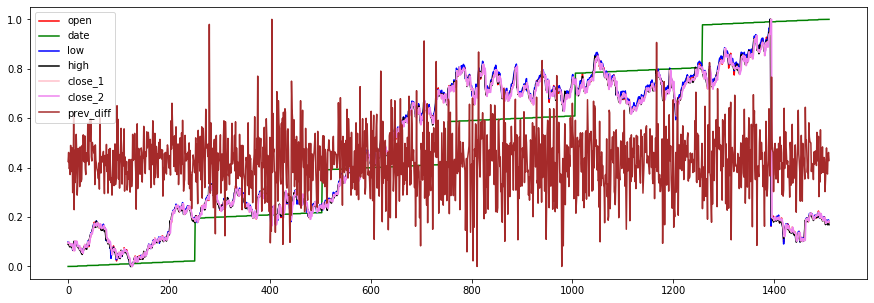

In [39]:
#Plotting again, this time along with date feature
plt.figure(figsize=(15, 5));
plt.plot(X_train.open.values, color='red', label='open')
plt.plot(X_train.date.values, color='green', label='date')
plt.plot(X_train.low.values, color='blue', label='low')
plt.plot(X_train.high.values, color='black', label='high')
plt.plot(X_train.close_1.values, color='pink', label='close_1')
plt.plot(X_train.close_2.values, color='violet', label='close_2')
plt.plot(X_train.prev_diff.values, color='brown', label='prev_diff')
plt.legend(loc='best')
plt.show()

Features seems to work well. 

In [40]:
#resulting shape
print(X_train.shape , Y_train.shape)
print("="*50)
print(X_test.shape, Y_test.shape)

(1510, 7) (1510,)
(252, 7) (252,)


# Model

In [13]:
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [62]:
#All the XGBregressor parameters that needs to be tuned.
#After checking, we have only kept the parameters which are having a significant impact on the results

parameters = {'colsample_bytree':[0.2, 0.4, 0.6, 0.8, 1.0],
              #'colsample_bylevel':[0.2, 0.4, 0.6, 0.8, 1.0],
              #'colsample_bynode':[0.2, 0.4, 0.6, 0.8, 1.0],
              'n_estimators' : [5, 10, 100, 500],
              #'max_depth' : [*range(3,8,2)],
              'subsample' : [0.6, 0.8, 1.0],
              'learning_rate' : [0.01, 0.1 , 0.3]
             }

In [63]:
#Hyperparameter tuning using GridSearchCV on XGBregressor

XGB= XGBRegressor(objective='reg:squarederror', booster='gbtree', n_jobs=-1, gamma=0)
clf = GridSearchCV(XGB, parameters, scoring='neg_mean_squared_error',cv=5)
clf.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=-1, nthread=None,
                                    objective='reg:squarederror',
                                    random_s...a=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.

In [61]:
#Getting the best set of parameters and the best MSE value achieved on the validation data 
print(clf.best_estimator_)
print('*'*100)
print(clf.best_score_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
****************************************************************************************************
-1.2009970761716133


In [64]:
#Using the best set of parameters to train the model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

XGB.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

Predicting the value 

In [65]:
y_pred=XGB.predict(X_test)
y_actual = np.array(Y_test)

In [67]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_actual, y_pred))

In [68]:
rms

17.627271946964196

Plotting the Actual vs Predicted closing prices.

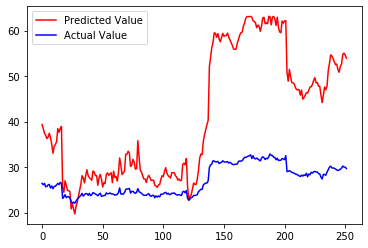

In [77]:
plt.plot(y_pred, color = 'r' , label = "Predicted Value")
plt.plot(y_actual , color = 'b' , label = "Actual Value")
plt.legend()
plt.show()

__Conclusion__

Although the scores aren't that bad given how unpredictable stock market can be, we have not got the optimum results using XGBoost.